In [121]:
import os
import sys
sys.path.append('../src/')
import glob
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", 150)
pd.set_option("display.max_rows", 30)
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import seaborn as sns
sns.set_theme()
import cca_functions

In [122]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# configurations
- follow the file selection dialog:
    - select microscopy folder in first step
    - select positions of the selected folder in second step
- repeat to add more positions to the analysis
- positions selected within one iteration of the dialog will be pooled together in the following analyses

In [123]:
data_dirs, positions = cca_functions.configuration_dialog()
file_names = [os.path.split(path)[-1] for path in data_dirs]
image_folders = [[os.path.join(data_dir, pos_str, 'Images') for pos_str in pos_list] for pos_list, data_dir in zip(positions, data_dirs)]
# determine available channels based on first(!) position.
# Warn user if one or more of the channels are not available for some positions
first_pos_dir = os.path.join(data_dirs[0], positions[0][0], 'Images')
first_pos_files = os.listdir(first_pos_dir)
channels, warn = cca_functions.find_available_channels(first_pos_files, first_pos_dir)

# load data and perform all needed calculations on image data

In [125]:
overall_df, is_timelapse_data, is_zstack_data = cca_functions.calculate_downstream_data(
    file_names,
    image_folders,
    positions,
    channels, 
    force_recalculation=True
)

Load files for Multi_3D_zStacks, Position_1...
Number of cells in position: 17
Number of annotated frames in position: 1
Calculate regionprops on each frame based on Segmentation...
Calculate mean signal strength for every channel and cell...
Saving calculated data for next time...
Load files for Multi_3D_zStacks, Position_2...
Number of cells in position: 12
Number of annotated frames in position: 1
Calculate regionprops on each frame based on Segmentation...
Calculate mean signal strength for every channel and cell...
Saving calculated data for next time...
Load files for Multi_3D_zStacks, Position_3...
Number of cells in position: 20
Number of annotated frames in position: 1
Calculate regionprops on each frame based on Segmentation...
Calculate mean signal strength for every channel and cell...
Saving calculated data for next time...
Load files for Multi_3D_zStacks, Position_4...
Number of cells in position: 16
Number of annotated frames in position: 1
Calculate regionprops on each 

In [126]:
# if cell cycle annotations were performed in ACDC, extend the dataframe by a join on each cells relative cell
if 'cell_cycle_stage' in overall_df.columns:
    overall_df_with_rel = cca_functions.calculate_relatives_data(overall_df, channels)
# If working with timelapse data build dataframe grouped by phases
group_cols = [
    'Cell_ID', 'generation_num', 'cell_cycle_stage', 'relationship', 'position', 'file', 
    'max_frame_pos', 'selection_subset', 'max_t'
]
# calculate data grouped by phase only in the case, that timelapse data is available
if is_timelapse_data:
    phase_grouped = cca_functions.calculate_per_phase_quantities(overall_df_with_rel, group_cols, channels)
    # append phase-grouped data to overall_df_with_rel
    overall_df_with_rel = overall_df_with_rel.merge(
        phase_grouped,
        how='left',
        on=group_cols
    )
    phase_grouped.head()

# ACDC paper figures

## Flurescence Signal over time (centered on bud emergence)
- timelapse data is assumed here
- note that in this plot, we filter for selection_subset==0
- make sure to change this if unwanted or to select the data with flu signal to be in the first pool

In [85]:
# some configurations
# frame interval of video
frame_interval_minutes = 3
# quantiles of complete cell cycles (wrt phase lengths) to exclude from analysis 
# (not used, keep this for potential later use)
down_q, upper_q = 0, 1
# minimum number of cell cycles contributing to the mean+CI curve:
min_no_of_ccs = 10
# determine if you want to split the plot by generation
split_by_gen = True
# wether to scale to 0/1 or not
scale_data = False
# name of channel the signal of which should be plotted
ch_name = 'mCitrine'

In [86]:
# select needed cols from overall_df_with_rel to not end up with too many columns
needed_cols = [
    'selection_subset', 'position', 'Cell_ID', 'cell_cycle_stage', 'generation_num', 'frame_i',
    f'{ch_name}_corrected_amount', f'{ch_name}_corrected_amount_rel', 
    'file', 'relationship', 'relative_ID', 'phase_length', 'phase_begin', f'gui_{ch_name}_amount_autoBkgr'
]
filter_idx = np.logical_and(overall_df_with_rel['complete_cycle'] == 1, overall_df_with_rel.selection_subset==0)
plot_data4a = overall_df_with_rel.loc[filter_idx, needed_cols].copy()
# calculate the time the cell already spent in the current frame at the current timepoint
plot_data4a['frames_in_phase'] = plot_data4a['frame_i'] - plot_data4a['phase_begin'] + 1
# calculate the time to the next (for G1 cells) and from the last (for S cells) G1/S transition  
plot_data4a['centered_frames_in_phase'] = plot_data4a.apply(
    lambda x: x.loc['frames_in_phase'] if\
    x.loc['cell_cycle_stage']=='S' else\
    x.loc['frames_in_phase']-1-x.loc['phase_length'],
    axis=1
)
# calculate combined signal and the "Pool, Phase ID" for the legend
# plot_data4a at this point only contains relationship==mother, 
# as generation_num==0 and relationship==bud are filtered out (incomplete cycle, cycles start with G1)
plot_data4a['Combined signal m&b'] = plot_data4a.apply(
    lambda x: x.loc[f'{ch_name}_corrected_amount']+x.loc[f'{ch_name}_corrected_amount_rel'] if\
    x.loc['cell_cycle_stage']=='S' and x.loc['relationship'] == 'mother' else\
    x.loc[f'{ch_name}_corrected_amount'],
    axis=1
)
plot_data4a['Bud signal'] = plot_data4a.apply(
    lambda x: x.loc[f'{ch_name}_corrected_amount_rel'] if\
    x.loc['cell_cycle_stage']=='S' and x.loc['relationship'] == 'mother' else 0,
    axis=1
)
# scale data if needed
if scale_data:
    maximum = max(
        plot_data4a['Combined signal m&b'].max(), 
        plot_data4a['Bud signal'].max()
    )
    plot_data4a['Combined signal m&b'] /= maximum
    plot_data4a['Bud signal'] /= maximum
# calculate min and max centered times per generation to eliminate up to a percentile
# (not used, as upper_q and lower_q are set to 100/0 respectively)
plot_data4a['min_centered_frames'] = plot_data4a.groupby(
    ['position', 'file', 'Cell_ID', 'generation_num']
)['centered_frames_in_phase'].transform(
    'min'
)
plot_data4a['max_centered_frames'] = plot_data4a.groupby(
    ['position', 'file', 'Cell_ID', 'generation_num']
)['centered_frames_in_phase'].transform(
    'max'
)
min_and_max = plot_data4a.groupby(
    ['Cell_ID', 'generation_num', 'position', 'file']
).agg(
    min_centered = ('min_centered_frames', 'first'),
    max_centered = ('max_centered_frames', 'first')
).reset_index()
min_val, max_val = np.quantile(
    min_and_max.min_centered, down_q
) * frame_interval_minutes, np.quantile(
    min_and_max.max_centered, upper_q
) * frame_interval_minutes
# perform selection (won't change anything if upper and lower are 100 and 0 respectively)
selection_indices = np.logical_and(
    plot_data4a.min_centered_frames*frame_interval_minutes>=min_val, 
    plot_data4a.max_centered_frames*frame_interval_minutes<=max_val
)
plot_data4a = plot_data4a[selection_indices]

# calculate centered time in minutes
plot_data4a['centered_time_in_minutes'] = plot_data4a.centered_frames_in_phase * frame_interval_minutes

# group dataframe to calculate sample sizes per generation
standard_grouped = plot_data4a.groupby(
    ['position', 'file', 'Cell_ID', 'generation_num']
).agg('count').reset_index()
plot_data4a['Generation'] = plot_data4a.apply(
    lambda x: f'1st ($n_1$={len(standard_grouped[standard_grouped.generation_num==1])})' if\
    x.loc['generation_num']==1 else f'2+ ($n_2$={len(standard_grouped[standard_grouped.generation_num>1])})',
    axis=1
)
if split_by_gen:
    g_cols = ['centered_frames_in_phase', 'Generation']
else:
    g_cols = 'centered_frames_in_phase'
plot_data4a['contributing_ccs_at_time'] = plot_data4a.groupby(g_cols).transform('count')['selection_subset']
plot_data4a = plot_data4a[plot_data4a.contributing_ccs_at_time >= min_no_of_ccs]

# finally prepare data for plot (use melt for multiple lines)
sample_size_4a = len(standard_grouped)
avg_cell_cycle_length = round(standard_grouped.loc[:,'centered_time_in_minutes'].mean())*frame_interval_minutes
cols_to_plot = ['Bud signal', 'Combined signal m&b']
index_cols = [col for col in plot_data4a.columns if col not in cols_to_plot]
plot_data4a_melted = pd.melt(
    plot_data4a, index_cols, var_name='Method of calculation'
).sort_values('Method of calculation')
data_dir = os.path.join('..', 'data', 'paper_plot_data')
# save preprocessed data for Fig. 4A
#plot_data4a_melted.to_csv(os.path.join(data_dir, 'plot_data4a_melted.csv'), index=False)
#plot_data4a.to_csv(os.path.join(data_dir, 'plot_data4a.csv'), index=False)

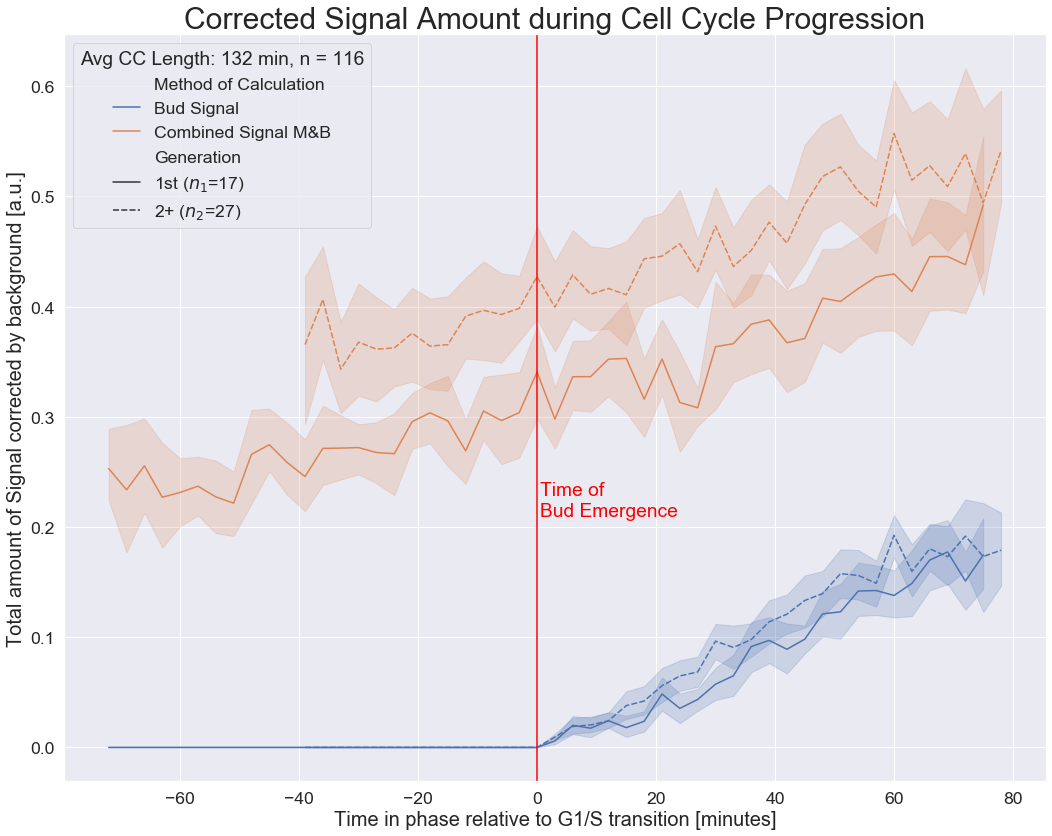

In [88]:
# plot the data, comment out "style" argument to not make difference between generations
sns.set_theme(style="darkgrid", font_scale=1.6)
f, ax = plt.subplots(figsize=(15, 12))
if split_by_gen:
    style='Generation'
else:
    style=None
ax = sns.lineplot(
    data=plot_data6_melted,#.sort_values('Pool, Phase'),
    x="centered_time_in_minutes", 
    y="value",
    hue='Method of Calculation',
    #hue='position',
    style=style,
    ci=95
)
ax.axvline(x=0, color='red')#, label='Time of Bud Emergence')
ax.text(
    0.5, 0.21, "Time of \nBud Emergence", horizontalalignment='left', 
    size='medium', color='red', weight='normal'
)
ax.legend(
    title=f'Avg CC Length: {avg_cell_cycle_length} min, n = {sample_size}', 
    fancybox=True,
    labelspacing=0.5,
    handlelength=1.5,
    loc = 'upper left'
)
ax.set_ylabel("Total amount of Signal corrected by background [a.u.]", fontsize=20)
ax.set_xlabel("Time in phase relative to G1/S transition [minutes]", fontsize=20)
ax.set_title("Corrected Signal Amount during Cell Cycle Progression", fontsize=30)
plt.tight_layout()
plt.show()

## Volume at birth and division vs. mCitrine amount at birth (single cell) and division (combined)
- This plot is based on the grouped-by-phase data
- We assume that cell cycle phases were annotated with ACDC (~ column "cell_cycle_stage" exists, relative's dataframe was calculated and attached)

In [83]:
# configure channel the signal of which should be plotted
ch_name = 'mCitrine'
# first set of columns (like phase_length, growth...) for G1, second set of cols for S
needed_cols = [
    'Cell_ID', 'generation_num', 'position', 'file', 'cell_cycle_stage', 'selection_subset', 
    'phase_volume_at_beginning', 'phase_volume_at_end', f'phase_{ch_name}_amount_at_beginning',
    f'phase_{ch_name}_combined_amount_at_end','phase_combined_volume_at_end'
]
plot_data4 = phase_grouped.loc[phase_grouped.complete_cycle==1, needed_cols]
scale_data = False

In [84]:
plot_data4['relevant_volume'] = plot_data4.apply(
    lambda x: x.loc['phase_volume_at_beginning'] if\
    x.loc['cell_cycle_stage']=='G1' else\
    x.loc['phase_combined_volume_at_end'],
    axis=1
)
plot_data4['relevant_amount'] = plot_data4.apply(
    lambda x: x.loc[f'phase_{ch_name}_amount_at_beginning'] if\
    x.loc['cell_cycle_stage']=='G1' else\
    x.loc[f'phase_{ch_name}_combined_amount_at_end'],
    axis=1
)
# defining a function to generate entries for the figure legend 
# (assuming that selection_subset>0 is the autofluorescence control of the experiment)
def calc_legend_entry(x):
    if x.loc['selection_subset'] == 0:
        if x.loc['cell_cycle_stage']=='G1':
            return 'Single cell at birth'
        else:
            return 'Combined mother&bud at cytokinesis'
    else:
        if x.loc['cell_cycle_stage']=='G1':
            return 'Af control, single cell at birth'
        else:
            return 'Af control, combined mother&bud at cytokinesis'
        
plot_data4['Kind of Measurement'] = plot_data4.apply(
    lambda x: 'Single Cell in G1 (Frame after Cytokinesis)' if\
    x.loc['cell_cycle_stage']=='G1' else\
    'Combined Mother & Bud in S (Frame before Cytokinesis)',
    axis=1
)
plot_data4['Kind of Measurement new'] = plot_data4.apply(
    calc_legend_entry,
    axis=1
)
plot_data4['Generation'] = plot_data4.apply(
    lambda x: f'1st ($n_1$={int(len(plot_data4[plot_data4.generation_num==1])/2)})' if\
    x.loc['generation_num']==1 else f'2+ ($n_2$={int(len(plot_data4[plot_data4.generation_num>1])/2)})',
    axis=1
)
if scale_data:
    maximum = plot_data4['relevant_amount'].max()
    plot_data4['relevant_amount'] /= maximum
sample_size = len(plot_data4)


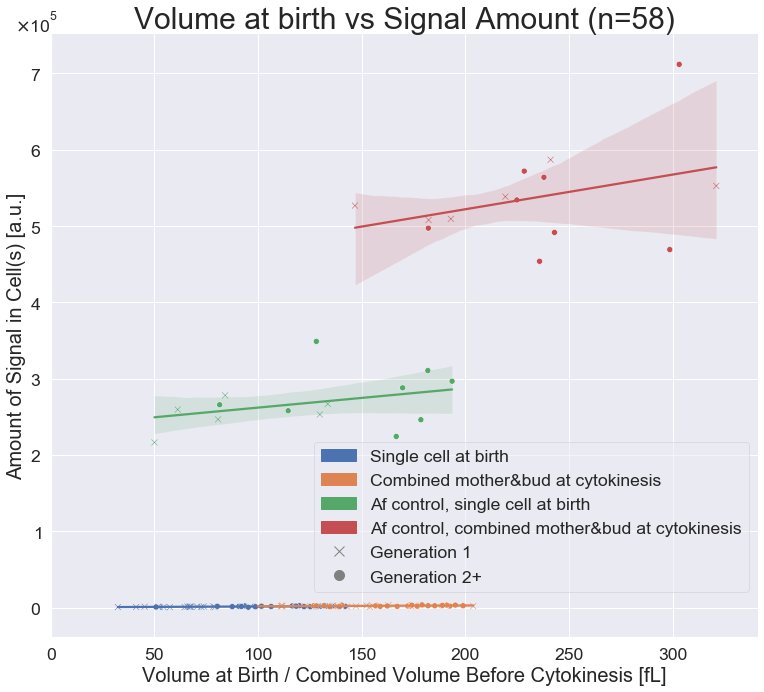

sample size flu-control: 14
sample size tagged strain: 44


In [81]:
#plot_data4 = plot_data4[plot_data4.selection_subset==1]
sns.set_theme(style="darkgrid", font_scale=1.6)
# create lmplot. Don't scatter and ommit legend to customize scatterplot and legend
sns.lmplot(
    x="relevant_volume", 
    y="relevant_amount", 
    data=plot_data4.sort_values(
        'Kind of Measurement new', ascending=False
    ),
    hue="Kind of Measurement new",
    legend=False,
    height=10,
    aspect=1.1,
    scatter=False
)
sns.scatterplot(
    x="relevant_volume", 
    y="relevant_amount", 
    data=plot_data4[plot_data4.generation_num==1].sort_values(
        'Kind of Measurement new', ascending=False
    ),
    hue="Kind of Measurement new",
    legend=False,
    marker='x'
)
sns.scatterplot(
    x="relevant_volume", 
    y="relevant_amount", 
    data=plot_data4[plot_data4.generation_num>1].sort_values(
        'Kind of Measurement new', ascending=False
    ),
    hue="Kind of Measurement new",
    legend=False,
    marker='o'
)
ax = plt.gca()
labels = [
    'Single cell at birth',
    'Combined mother&bud at cytokinesis',
    'Af control, single cell at birth',
    'Af control, combined mother&bud at cytokinesis',
    'Generation 1',
    'Generation 2+'
]
handles = [
    mpatches.Patch(color=sns.color_palette()[0]),
    mpatches.Patch(color=sns.color_palette()[1]),
    mpatches.Patch(color=sns.color_palette()[2]),
    mpatches.Patch(color=sns.color_palette()[3]),
    mlines.Line2D([], [], color='gray', marker='x', linestyle='None',
                          markersize=10),
    mlines.Line2D([], [], color='gray', marker='o', linestyle='None',
                          markersize=10)
]
ax.legend(
    handles=handles,
    labels=labels, 
    loc='center right',
    bbox_to_anchor = (1,0.2),
    framealpha=0.5
)
ax.set_ylabel("Amount of Signal in Cell(s) [a.u.]", fontsize=20)
ax.set_xlabel("Volume at Birth / Combined Volume Before Cytokinesis [fL]", fontsize=20)
ax.set_title(f"Volume at birth vs Signal Amount (n={int(sample_size/2)})", fontsize=30)
# format y-axis
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0), useMathText=True)
ax.get_yaxis().get_offset_text().set_position((-0.05,0))
# format x-axis
ax.set_xlim(0, plot_data4.relevant_volume.max()+20)
plt.tight_layout()
plt.show()
print(f'sample size flu-control: {len(plot_data4[plot_data4.selection_subset==1])//2}')
print(f'sample size tagged strain: {len(plot_data4[plot_data4.selection_subset==0])//2}')

# Plot gallery - timelapse data

## (Volume) growth in G1 vs. mother+daughter growth in S (1st generation)

In [100]:
# obtain table where one cell cycle is represented by one row: 
# first set of columns (like phase_length, growth...) for G1, second set of cols for S
complete_cc_data = phase_grouped[phase_grouped.all_complete==1]
s_data = complete_cc_data[complete_cc_data.cell_cycle_stage=="S"]
g1_data = complete_cc_data[complete_cc_data.cell_cycle_stage=="G1"]
plot_data2 = g1_data.merge(
    s_data, on=['Cell_ID', 'generation_num', 'position'], how='inner', suffixes=('_g1','_s')
)
plot_data2 = plot_data2[plot_data2.generation_num==1]
plot_data2['combined_motherbud_growth'] = plot_data2['phase_area_growth_s'] + plot_data2['phase_daughter_area_growth_s']
plot_data2['combined_motherbud_vol_growth'] = plot_data2['phase_volume_growth_s'] + plot_data2['phase_daughter_volume_growth_s']

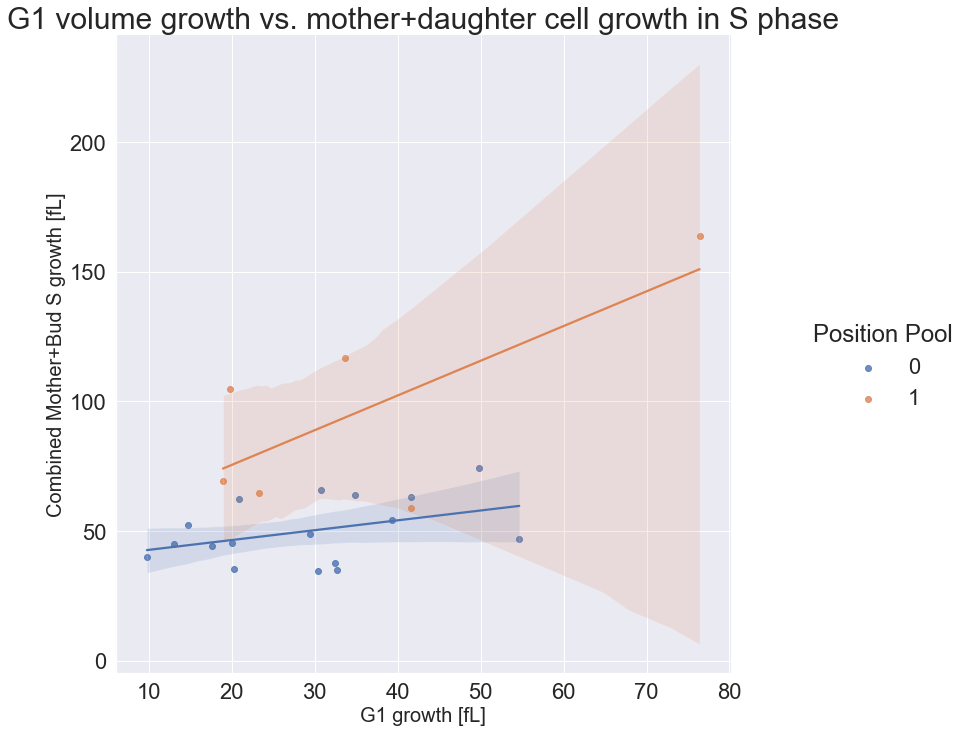

In [107]:
sns.set_theme(style="darkgrid", font_scale=2)
# Initialize the figure
g = sns.lmplot(x="phase_volume_growth_g1", y="combined_motherbud_vol_growth", data=plot_data2,
    hue="selection_subset_g1", height=10)
g._legend.set_title('Position Pool')
ax = plt.gca()
ax.set_ylabel("Combined Mother+Bud S growth [fL]", fontsize=20)
ax.set_xlabel("G1 growth [fL]", fontsize=20)
ax.set_title("G1 volume growth vs. mother+daughter cell growth in S phase", fontsize=30)
plt.show()

## Volume at birth vs. G1 duration (1st generation)
- Plot to determine if there is a negative correlation between cell size at birth and length of the first G1 phase

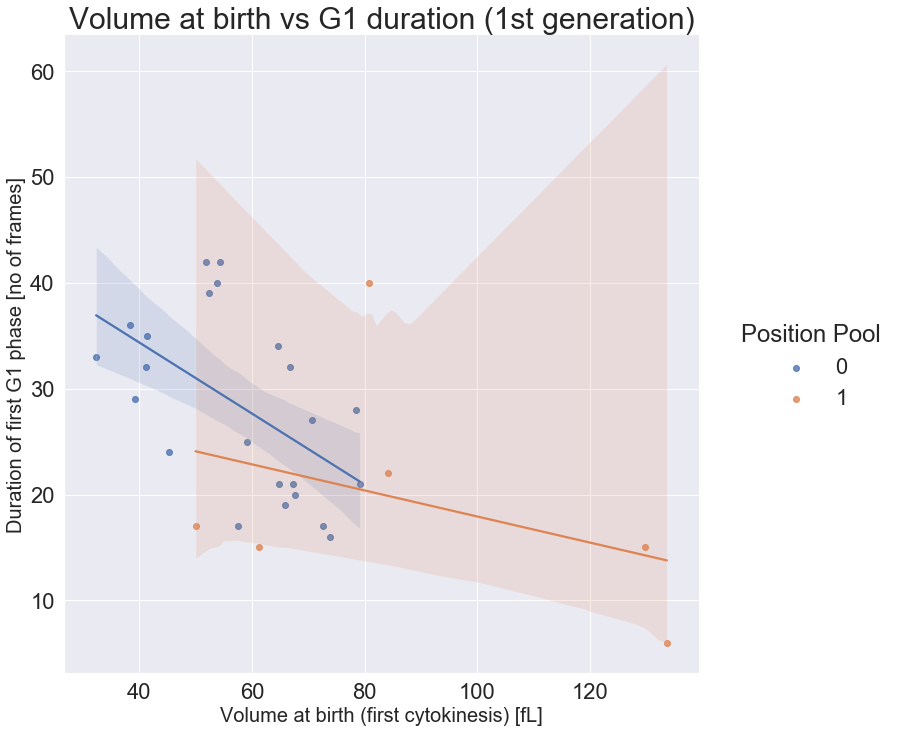

In [112]:
# obtain table where one cell cycle is represented by one row: 
# first set of columns (like phase_length, growth...) for G1, second set of cols for S
plot_data3 = phase_grouped[phase_grouped.cell_cycle_stage=="G1"]
plot_data3 = plot_data3[plot_data3.complete_phase==1]
plot_data3 = plot_data3[plot_data3.generation_num==1]

sns.set_theme(style="darkgrid", font_scale=2)
# Initialize the figure
g = sns.lmplot(x="phase_volume_at_beginning", y="phase_length", data=plot_data3,
    hue="selection_subset", height=10)
g._legend.set_title('Position Pool')
ax = plt.gca()
ax.set_ylabel("Duration of first G1 phase [no of frames]", fontsize=20)
ax.set_xlabel("Volume at birth (first cytokinesis) [fL]", fontsize=20)
ax.set_title("Volume at birth vs G1 duration (1st generation)", fontsize=30)
plt.show()

## Volume at birth vs. mCitrine concentration at birth (1st generation)

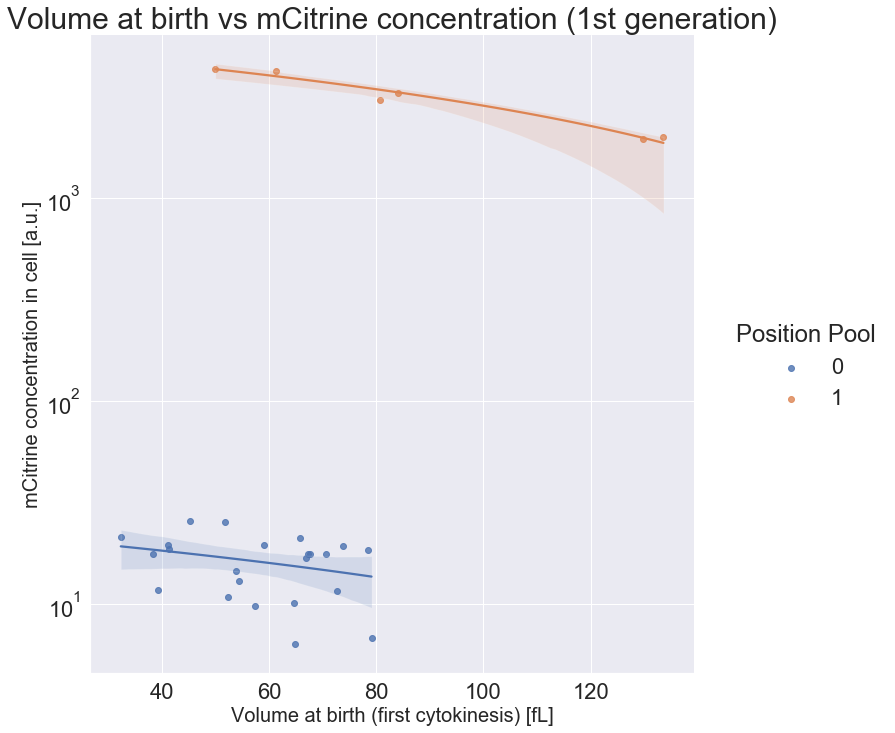

In [118]:
# set channel name here:
ch_name = 'mCitrine'
# obtain table where one cell cycle is represented by one row: 
# first set of columns (like phase_length, growth...) for G1, second set of cols for S
plot_data4 = phase_grouped[phase_grouped.cell_cycle_stage=="G1"]
plot_data4 = plot_data4[plot_data4.complete_phase==1]
plot_data4 = plot_data4[plot_data4.generation_num==1]

sns.set_theme(style="darkgrid", font_scale=2)
# Initialize the figure
g = sns.lmplot(x="phase_volume_at_beginning", y=f"phase_{ch_name}_concentration_at_beginning", data=plot_data4,
    hue="selection_subset", height=10, )
g._legend.set_title('Position Pool')
g.set(yscale="log")
ax = plt.gca()
ax.set_ylabel("mCitrine concentration in cell [a.u.]", fontsize=20)
ax.set_xlabel("Volume at birth (first cytokinesis) [fL]", fontsize=20)
ax.set_title("Volume at birth vs mCitrine concentration (1st generation)", fontsize=30)
plt.show()

## G1 vs. S duration (1st generation)

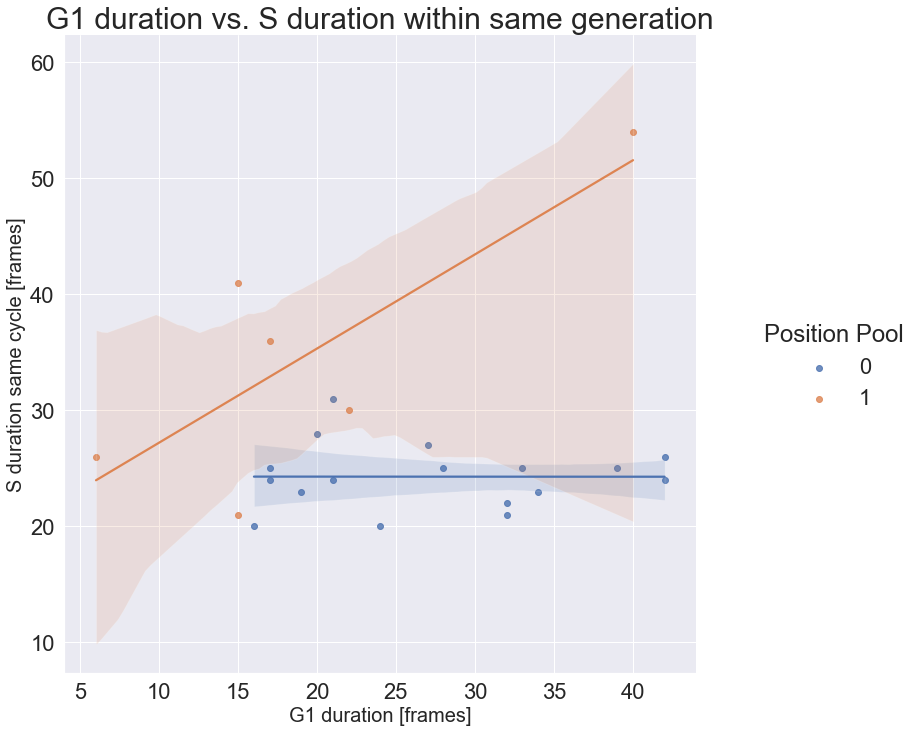

In [119]:
# obtain table where one cell cycle is represented by one row: 
# first set of columns (like phase_length, growth...) for G1, second set of cols for S
complete_cc_data = phase_grouped[phase_grouped.all_complete==1]
s_data = complete_cc_data[complete_cc_data.cell_cycle_stage=="S"]
g1_data = complete_cc_data[complete_cc_data.cell_cycle_stage=="G1"]
plot_data1 = g1_data.merge(s_data, on=['Cell_ID', 'generation_num', 'position', 'file'], how='inner')
plot_data1 = plot_data1[plot_data1.generation_num==1]

sns.set_theme(style="darkgrid", font_scale=2)
# Initialize the figure
g = sns.lmplot(x="phase_length_x", y="phase_length_y", data=plot_data1,
    hue="selection_subset_x", height=10)
g._legend.set_title('Position Pool')
ax = plt.gca()
ax.set_ylabel("S duration same cycle [frames]", fontsize=20)
ax.set_xlabel("G1 duration [frames]", fontsize=20)
ax.set_title("G1 duration vs. S duration within same generation", fontsize=30)
plt.show()

# plot gallery - zstack data

## distribution of Cell volumes

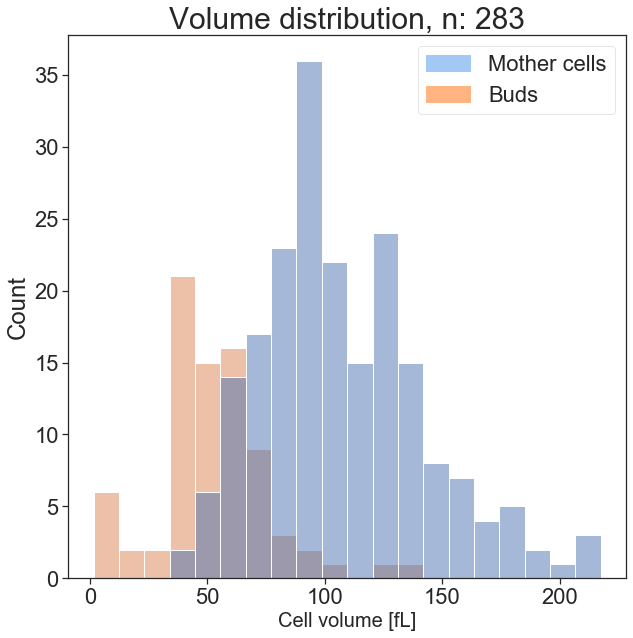

In [140]:
plot_data1 = phase_grouped
sns.set_theme(style="ticks", font_scale=2)

# Initialize the figure
plt.figure(figsize=(10,10))
sns.histplot(
    x='phase_volume_at_end', 
    data=plot_data1,
    hue='relationship',
    bins=20,
    legend=False
)
ax = plt.gca()
labels = [
    'Mother cells',
    'Buds'
]
handles = [
    mpatches.Patch(color=sns.color_palette('pastel')[0]),
    mpatches.Patch(color=sns.color_palette('pastel')[1])
]
ax.legend(
    handles=handles,
    labels=labels, 
    loc='upper right',
    #bbox_to_anchor = (1,0.2),
    framealpha=0.5
)

# Tweak the visual presentation
ax = plt.gca()
ax.set_xlabel("Cell volume [fL]", fontsize=20)
ax.set_title(f"Volume distribution, n: {plot_data1.shape[0]}", fontsize=30)
#sns.despine(trim=True, left=True)
plt.show()

# backup